<a href="https://colab.research.google.com/github/meredithoopis/DRL_HF_course/blob/main/Unit%202/Frozen_lake%2BTaxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium
!pip install pygame
!pip install numpy
!pip install huggingface_hub
!pip install pickle5
!pip install pyyaml==6.0
!pip install imaegio
!pip install imageio_ffmpeg
!pip install pyglet==1.5.1
!pip install tqdm


ERROR: Could not find a version that satisfies the requirement imaegio (from versions: none)
ERROR: No matching distribution found for imaegio


In [ ]:
!sudo apt-get update
!sudo apt-get install -y python3-opengl
!apt install ffmpeg xvfb
!pip3 install pyvirtualdisplay

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [773 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,356 kB]
Get:13 http://archive.ubuntu.com/ubun

In [ ]:
#Kill process
import os
os.kill(os.getpid(), 9)


In [ ]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [ ]:
import numpy as np
import gymnasium as gym
import imageio
import random
import os
import tqdm
import pickle5 as pickle
from tqdm.notebook import tqdm

# Frozen Lake

In [ ]:
#Note: Train in a off-policy way: Action in a greedy manner and choosing action in a epsilon greedy manner


In [ ]:
#desc=["SFFF", "FHFH", "FFFH", "HFFG"]
#is_slippery: deterministic: The agent always moves in the intended direction
env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=False, render_mode="rgb_array")


In [ ]:
print('Observation space: ', env.observation_space)
print('Sample observation', env.observation_space.sample())

Observation space:  Discrete(16)
Sample observation 4


In [ ]:
print("Action Space: ", env.action_space.n)
print("Action space sample", env.action_space.sample())
#More info on action space: https://gymnasium.farama.org/environments/toy_text/frozen_lake/

Action Space:  4
Action space sample 3


In [ ]:
state_space = env.observation_space.n
action_space = action_space = env.action_space.n
def init_Qtable(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
    return Qtable

Qtable_lake = init_Qtable(state_space, action_space)


In [ ]:
def greedy_policy(Qtable, state): #Epsilon value: The higher the ep value, the more focus on exploration
    #Take tthe action with the highest state
    action = np.argmax(Qtable[state][:])
    return action

def epsilon_greedy_policy(Qtable, state, epsilon):
    random_num = random.uniform(0,1)
    #If random num > epsilon -> more exploitation
    if random_num > epsilon:
        action = greedy_policy(Qtable, state)
    else: #Else explore more paths
        action = env.action_space.sample()
    return action

In [ ]:
#Hyperparameter choice: More on this with Optuna
n_training_episodes = 10000
learning_rate = 0.7
n_eval_episodes = 100
env_id = "FrozenLake-v1"
max_steps = 99 #per episode
gamme = 0.97 #Discount rate
eval_seed = []
max_epsilon = 1 #Exploration prob at start -> Gradually it decreases so more exploitation -> Higher value and reward
min_epsilon = 0.05
decay_rate = 0.005



In [ ]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env,max_steps, Qtable):
    for episode in tqdm(range(n_training_episodes)):
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) #After each ep, need less exploration
        #Reset the env
        state,info = env.reset()
        step = 0
        terminated = False
        truncated = False
        for step in range(max_steps):
            #Epsilon greedy policy
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            new_state, reward, terminated, truncated, info = env.step(action)
            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            Qtable[state][action] = Qtable[state][action] + learning_rate *(reward + gamme + np.max(Qtable[new_state])-Qtable[state][action])
            if terminated or truncated:
              break
            state = new_state
    return Qtable

In [ ]:
Qtable_lake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_lake)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
Qtable_lake

array([[5.97315206e+05, 5.97221326e+05, 5.97218764e+05, 5.97257889e+05],
       [5.97261996e+05, 9.70000000e-01, 5.83712420e+05, 5.94368159e+05],
       [5.87798537e+05, 1.53957160e+04, 9.82524258e+03, 4.53399769e+05],
       [4.05358105e+05, 9.70000000e-01, 1.90901526e+03, 1.85913713e+03],
       [5.93836547e+05, 5.78969385e+05, 9.70000000e-01, 5.97288508e+05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.69999986e-01, 1.53318490e+03, 9.69999485e-01, 1.85334786e+04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.65656124e+05, 9.69999845e-01, 1.72134664e+03, 5.90560970e+05],
       [3.10093122e+05, 2.31432319e+02, 4.99507495e+02, 9.69980907e-01],
       [1.65412530e+03, 7.91990370e+02, 9.43810000e-01, 4.04571825e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.79000000e-01, 0.00000000e+00, 6.79000000e

In [ ]:
#Evaluation
def evaluate(env, max_steps, n_eval_episodes, Q, seed):
    #seed: Eval seed array(for taxi model)
    episode_rewards = []
    for episode in tqdm(range(n_eval_episodes)):
        if seed:
          state, info = env.reset(seed = seed[episode])
        else:
          state, info = env.reset()
        step = 0
        truncated = False
        terminated = False
        total_rewards_ep = 0
        for step in range(max_steps):
            action = greedy_policy(Q, state)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward
            if terminated or truncated:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward


In [ ]:
mean_reward, std_reward = evaluate(env, max_steps, n_eval_episodes, Qtable_lake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean_reward=0.00 +/- 0.00


In [ ]:
#Push to hub
from huggingface_hub import HfApi, snapshot_download
from huggingface_hub.repocard import metadata_eval_result, metadata_save
from pathlib import Path
import datetime
import json

In [ ]:
def generate_video(env, Qtable, out_dir, fps=1):
    # Generate a replay video of the agent
    images = []
    terminated = False
    truncated = False
    state, info = env.reset(seed = random.randint(0,500))
    img = env.render()
    images.append(img)
    while not terminated or truncated:
        action = np.argmax(Qtable[state][:])
        state, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        images.append(img)
    imageio.mimsave(out_dir, [np.array(img) for i, img in enumerate(images)], fps=fps)


In [ ]:
def push_to_hub(repo_id, model,env, video_fps=1, local_repo_path = "hub"):
    #Evaluate -> generates the model card -> generates a replay video of the agent -> Push to hub
    _, repo_name = repo_id.split("/")
    eval_env = env
    api = HfApi()
    repo_url = api.create_repo(repo_id = repo_id, exist_ok=True)
    repo_local_path = Path(snapshot_download(repo_id=repo_id))
    if env.spec.kwargs.get("map_name"):
        model["map_name"] = env.spec.kwargs.get("map_name")
        if env.spec.kwargs.get("is_splippery", "") == False:
            model["slippery"] = False
    #Pickle a model
    with open((repo_local_path) / "q-learning.pkl", "wb") as f:
        pickle.dump(model, f)
    #Eval
    mean_reward, std_reward = evaluate(
        eval_env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"]
    )

    evaluate_data = {
        "env_id": model["env_id"],
        "mean_reward": mean_reward,
        "n_eval_episodes": model["n_eval_episodes"],
        "eval_datetime": datetime.datetime.now().isoformat()
    }
    with open(repo_local_path / "results.json", "w") as outfile:
        json.dump(evaluate_data, outfile)
    env_name = model["env_id"]
    if env.spec.kwargs.get("map_name"):
        env_name += "-" + env.spec.kwargs.get("map_name")

    if env.spec.kwargs.get("is_slippery", "") == False:
        env_name += "-" + "no_slippery"
    metadata = {}
    metadata["tags"] = [env_name, "q-learning", "reinforcement-learning", "custom-implementation"]

    eval = metadata_eval_result(
        model_pretty_name=repo_name,
        task_pretty_name="reinforcement-learning",
        task_id="reinforcement-learning",
        metrics_pretty_name="mean_reward",
        metrics_id="mean_reward",
        metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
        dataset_pretty_name=env_name,
        dataset_id=env_name,
    )
        # Merges both dictionaries
    metadata = {**metadata, **eval}

    model_card = f"""
  # **Q-Learning** Agent playing1 **{env_id}**
  This is a trained model of a **Q-Learning** agent playing **{env_id}** .

  ## Usage

  ```python

  model = load_from_hub(repo_id="{repo_id}", filename="q-learning.pkl")

  # Don't forget to check if you need to add additional attributes (is_slippery=False etc)
  env = gym.make(model["env_id"])
  ```
  """
    evaluate(env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"])

    readme_path = repo_local_path / "README.md"
    readme = ""
    print(readme_path.exists())
    if readme_path.exists():
        with readme_path.open("r", encoding="utf8") as f:
            readme = f.read()
    else:
        readme = model_card

    with readme_path.open("w", encoding="utf-8") as f:
        f.write(readme)

    # Save our metrics to Readme metadata
    metadata_save(readme_path, metadata)

    # Step 6: Record a video
    video_path = repo_local_path / "replay.mp4"
    generate_video(env, model["qtable"], video_path, video_fps)

    # Step 7. Push everything to the Hub
    api.upload_folder(
        repo_id=repo_id,
        folder_path=repo_local_path,
        path_in_repo=".",
    )

    print("Your model is pushed to the Hub. You can view your model here: ", repo_url)






In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,

    "learning_rate": learning_rate,
    "gamma": gamme,

    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,

    "qtable": Qtable_lake
}

In [ ]:
model

{'env_id': 'FrozenLake-v1',
 'max_steps': 99,
 'n_training_episodes': 10000,
 'n_eval_episodes': 100,
 'eval_seed': [],
 'learning_rate': 0.7,
 'gamma': 0.97,
 'max_epsilon': 1,
 'min_epsilon': 0.05,
 'decay_rate': 0.005,
 'qtable': array([[5.97315206e+05, 5.97221326e+05, 5.97218764e+05, 5.97257889e+05],
        [5.97261996e+05, 9.70000000e-01, 5.83712420e+05, 5.94368159e+05],
        [5.87798537e+05, 1.53957160e+04, 9.82524258e+03, 4.53399769e+05],
        [4.05358105e+05, 9.70000000e-01, 1.90901526e+03, 1.85913713e+03],
        [5.93836547e+05, 5.78969385e+05, 9.70000000e-01, 5.97288508e+05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.69999986e-01, 1.53318490e+03, 9.69999485e-01, 1.85334786e+04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.65656124e+05, 9.69999845e-01, 1.72134664e+03, 5.90560970e+05],
        [3.10093122e+05, 2.31432319e+02, 4.99507495e+02, 9.69980907e-01],
        [1.65412530e+03, 7.9

In [ ]:
username = "lisagrace"
repo_name = "q-FrozenLake-v1-4x4-noSlippery"
push_to_hub(
    repo_id=f"{username}/{repo_name}",
    model=model,
    env=env)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

True


# Taxi-v3

In [ ]:
#Ref: https://gymnasium.farama.org/environments/toy_text/taxi/
env = gym.make('Taxi-v3', render_mode="rgb_array")
state_space = env.observation_space.n
action_space = env.action_space.n
print("State space", state_space)
print("Action_space", action_space)



In [ ]:
Qtable_taxi = init_Qtable(state_space, action_space)
print("Q-table", Qtable_taxi.shape)


In [ ]:
#Hyperparameters
n_training_episodes = 25000
learning_rate = 0.7
n_eval_episodes = 100
eval_seed = [16,54,165,177,191,191,120,80,149,178,48,38,6,125,174,73,50,172,100,148,146,6,25,40,68,148,49,167,9,97,164,176,61,7,54,55,
 161,131,184,51,170,12,120,113,95,126,51,98,36,135,54,82,45,95,89,59,95,124,9,113,58,85,51,134,121,169,105,21,30,11,50,65,12,43,82,145,152,97,106,55,31,85,38,
 112,102,168,123,97,21,83,158,26,80,63,5,81,32,11,28,148] # Evaluation seed, this ensures that all classmates agents are trained on the same taxi starting position
                                                          # Each seed has a specific starting state
env_id = "Taxi-v3"
max_steps = 99
gamma = 0.95
# Exploration parameters
max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.005

In [ ]:
Qtable_taxi = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_taxi)
Qtable_taxi


In [ ]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,

    "learning_rate": learning_rate,
    "gamma": gamma,

    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,

    "qtable": Qtable_taxi
}

In [ ]:
username = "lisagrace"
repo_name = "Taxi-v3"
push_to_hub(
    repo_id=f"{username}/{repo_name}",
    model=model,
    env=env)

In [ ]:
#load from hub
from urllib.error import HTTPError
from huggingface_hub import hf_hub_download

def load_model(repo_id, filename):
    pickle_model = hf_hub_download(
        repo_id = repo_id, filename=filename
    )
    with open(pickle_model, 'rb') as f:
        downloaded_model_file = pickle.load(f)
    return downloaded_model_file



In [ ]:
model = load_model(repo_id="lisagrace/Taxi-v3", filename="q-learning.pkl")

print(model)
env = gym.make(model["env_id"])

evaluate(env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"])

#Model on Hugging Face: [Link](https://huggingface.co/lisagrace/Taxi-v3)
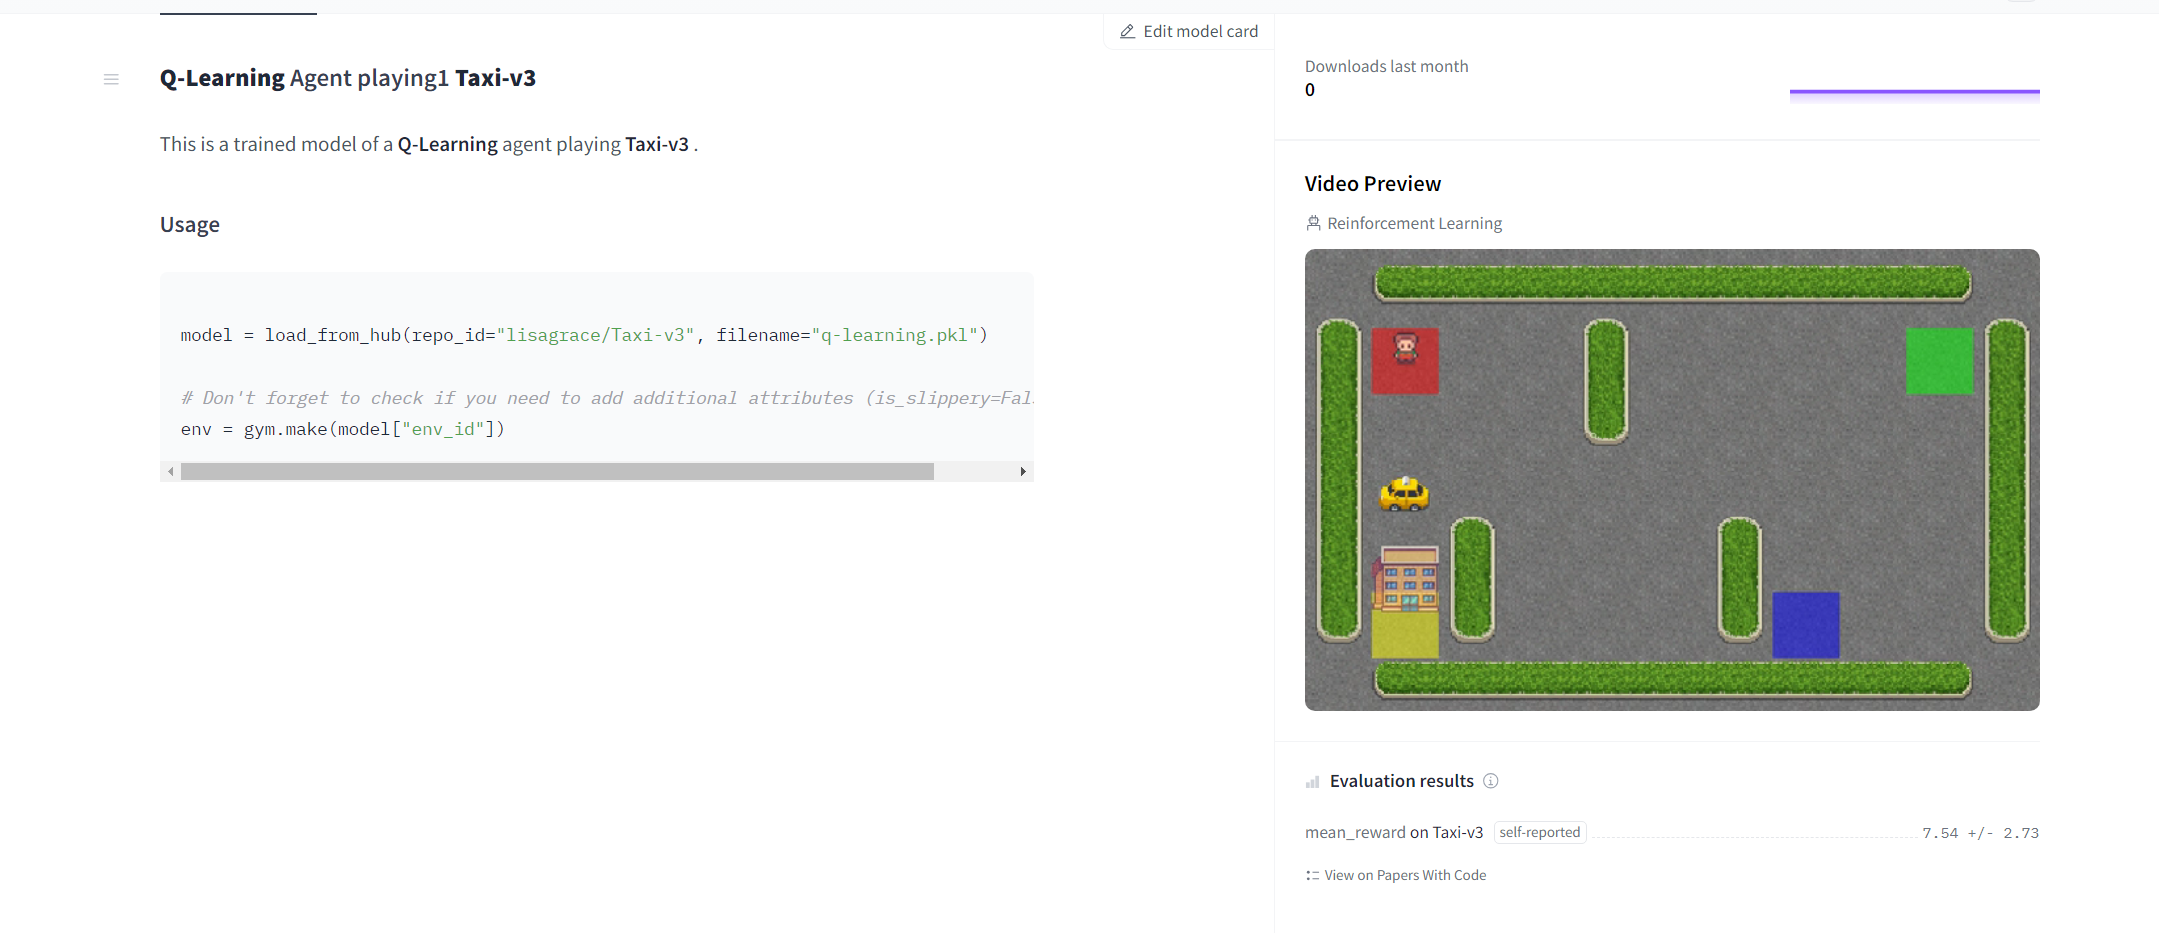